In [1]:
from __future__ import print_function
from IPython import get_ipython


 # CBO Applied to RL

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.dpi'] = 120

In [3]:
# hacky way of toggling between showing/hiding progress bar

# show
from tqdm.auto import tqdm, trange
# hide
# trange = lambda x, leave=None, position=0, desc=None: range(x)
# tqdm = lambda x, leave=None, position=0, desc=None: x

 ## $V$ -evaluation, continuous state space (5.1.)

 ### Outline

 - Markov decision process with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
 - Dynamics described by

 $$
 \begin{align}
 &s_{m+1} = s_{m} + \alpha(s_m)\epsilon + \sigma(s_m)\sqrt{\epsilon} Z_m \\
 &\alpha(s) = 2 \sin(s) \cos(s), \quad \sigma(s) = 1 + \cos(s)^2, \quad \epsilon = 0.1
 \end{align}
 $$

 - Immediate reward function, $R(s)=(\cos(2s)+1)$.
 - Discount factor $\gamma=0.9$.
 - 3 layer FCNN, $V(s;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons.

 $$
 \begin{align}
 &V(s ; \theta)=V\left(x ;\left\{w_{i}, b_{i}\right\}_{i=1}^{3}\right)=L_{w_{3}, b_{3}} \circ \cos \circ L_{w_{2}, b_{2}} \circ \cos \circ L_{w_{1}, b_{1}}((\cos s, \sin s)) \\
 &L_{w_{i}, b_{i}}(x)=w_{i} x+b_{i}, \quad w_{i} \in \mathbb{R}^{n_{i-1} \times n_{i}}, \quad b_{i} \in \mathbb{R}^{n_{i}}, \quad n_{0}=2, n_{1}=n_{2}=50, n_{3}=1
 \end{align}
 $$

 - $\theta^*$ is computed with Algorithms 1-4 based on trajectory $\{s_m\}_{m=1}^{10^6}$ with

 $$
 f\left(s_{m}, s_{m+1}, \theta\right)=R\left(s_{m}\right)+\gamma V\left(s_{m+1} ; \theta\right)-V\left(s_{m} ; \theta\right), \quad \tau=0.1, \quad M=1000
 $$

 - The SGD algorithm runs for a single epoch with the same initialization $\theta_0$.
 - Error at step $k$, $e_k$ is defined as $e_k=\| V(\cdot,\theta_k)-V^*\|_{L^2}$.
 - Reference $V^*(s)$ is computed by running Algorithm 1 for 10 epochs based on longer trajectory $\{s_m\}_{m=1}^{10^7}$, with $\tau=0.01$, $M=1000$.
 - Visualize $\log_{10}(e_k/e_0)$.

 Made one modification to paper:
 - Since $V(s,\theta)\mapsto V(s,\theta)+\delta$ is a symmetry in $f$, then a better way of measuring error, $e_k$, is
 $$
 e_k=\| V(\cdot,\theta_k)-V^* - \mu_k \|_2,\quad \mu_k = \int V(\cdot,\theta_k)-V^*
 $$

 ### Sampling Trajectory

In [4]:
def sample_trajectory(s_0, α, σ, ϵ, m):
    s_0_size = s_0.size()
    S = torch.zeros(m, *s_0_size)
    S[0] = s_0
    for i in range(m-1):
        S[i+1] = S[i]+α(S[i])*ϵ+σ(S[i])*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros(*s_0_size))
    return S

In [5]:
α = lambda s: 2*torch.sin(s)*torch.cos(s) 
σ = lambda s: 1+torch.cos(s)**2
ϵ = torch.tensor([0.1])
s_0 = torch.tensor([0.])
r = lambda s: torch.cos(2*s)+1

In [6]:
# S = sample_trajectory(s_0, α, σ, ϵ, int(1e6))
# R = r(S) 
# S_long = sample_trajectory(s_0, α, σ, ϵ, int(1e7))
# R_long = r(S_long) 

In [7]:
# torch.save(S_long, 'S_long.pt')
# torch.save(R_long, 'R_long.pt')
# torch.save(S, 'S.pt')
# torch.save(R, 'R.pt')

In [8]:
S_long = torch.load('S_long.pt')
R_long = torch.load('R_long.pt')
S = torch.load('S.pt')
R = torch.load('R.pt')

In [9]:
# plt.plot(S,".",markersize=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.1,alpha=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$s_i$");
# plt.show();
# plt.plot(R,".",markersize=0.1,alpha=0.1);
# plt.xlabel(r"$i$");
# plt.ylabel(r"$R(s_i)$");
# plt.show();

 ### SGD

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.apply(self.init_params)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

    def init_params(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight)
            nn.init.normal_(m.bias)

In [4]:
def gen_batches(N, M, Rem):
    P = torch.randperm(N)
    if Rem.size()[0] > 0:
        I = torch.cat((Rem, P), 0)
    else:
        I = P
    q = int(np.floor((P.size()[0]+Rem.size()[0])/M))
    B = I[:(q*M)].view(q, M)
    Rem = I[(q*M):]
    return B, Rem

In [5]:
def comp(V_net,V_net_comp,x_ls, n):
    diff = V_net(x_ls)-V_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff-torch.mean(diff))
def comp_0(V_net,V_net_comp,x_ls, n):
    return np.sqrt(2*np.pi/n)*torch.norm(V_net(x_ls)-V_net_comp(x_ls))

In [13]:
def V_eval_SGD_gen(update_step):
    def algo(V_net=Net(), M=1000, epochs=100, γ=0.9, τ= 0.01, S=S, R=R, α=α, σ=σ, ϵ=ϵ, V_net_comp=None, n_comp=1000):
        Rem = torch.tensor([])
        N = S.size()[0]
        i = 0
        if V_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n_comp+1)[:-1].view(-1,1)
            e = [comp(V_net,V_net_comp,x_ls, n_comp)]
        for k in trange(epochs, leave=False, position=0, desc="Epoch"):
            B, Rem = gen_batches(N-2,M, Rem)
            for B_θ in tqdm(B,leave=False, position=0,desc="Batch"): 
                update_step(V_net, γ, τ, S, R, B_θ,α=α, σ=σ, ϵ=ϵ)                
                with torch.no_grad():
                    for param in V_net.parameters():
                        param -= τ/M*param.grad
                if V_net_comp:
                    e.append(comp(V_net,V_net_comp,x_ls, n_comp))
        if V_net_comp:
            return V_net, torch.tensor(e)
        else:
            return V_net
    return algo

In [14]:
def UR_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=α, σ=σ, ϵ=ϵ):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    f_p = R[B_θ] + γ*V_net(ŝ_1) - V_net(s)
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    V_net.zero_grad()
    f_p.backward(f)

def DS_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    V_net.zero_grad()
    f.backward(f)

def BFF_G_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s + s_2 - s_1 
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
    V_net.zero_grad()
    (f*f̃).backward(torch.ones_like(f)/2.)
    
def BFF_L_SGD_update_step(V_net, γ, τ, S, R, B_θ, α=None, σ=None, ϵ=None):     
    s = S[B_θ]
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s + s_2 - s_1 
    f = R[B_θ] + γ*V_net(s_1) - V_net(s)
    f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
    V_net.zero_grad()
    f̃.backward(f)

In [15]:
# V_UR_SGD_star = V_eval_SGD_gen(UR_SGD_update_step)(S=S_long, R=R_long, M=1000, epochs=10, τ=0.01)

In [16]:
# torch.save(V_UR_SGD_star, "V_UR_SGD_star.pt")
V_UR_SGD_star = torch.load("V_UR_SGD_star.pt")

In [17]:
V_UR_SGD, e_UR_SGD = V_eval_SGD_gen(UR_SGD_update_step)(M=1000, epochs=1, τ=0.1, V_net_comp = V_UR_SGD_star)
V_DS_SGD, e_DS_SGD = V_eval_SGD_gen(DS_SGD_update_step)(M=1000, epochs=1, τ=0.1, V_net_comp = V_UR_SGD_star)
V_BFF_G_SGD, e_BFF_G_SGD = V_eval_SGD_gen(BFF_G_SGD_update_step)(M=1000, epochs=1, τ=0.1, V_net_comp = V_UR_SGD_star)
V_BFF_L_SGD, e_BFF_L_SGD = V_eval_SGD_gen(BFF_L_SGD_update_step)(M=1000, epochs=1, τ=0.1, V_net_comp = V_UR_SGD_star)

Epoch: 100%|██████████| 1/1 [00:10<00:00, 10.91s/it]

In [18]:
def plotV(V_s, e_s, lb_s, V_star, lb_star):
    fig, axs = plt.subplots(figsize=(12,5),ncols=2)
    x_s = torch.linspace(0,2*np.pi,1000)
    y_star = V_star(x_s.view(-1,1)).view(-1)
    y_s = torch.cat([V(x_s.view(-1,1)).view(1,-1) for V in V_s])
    y_s -= torch.mean(y_s-y_star.view(1,-1),axis=1).view(-1,1)
    axs[0].plot(x_s.detach().numpy(),y_star.detach().numpy(),label=lb_star,color="black")
    for j in range(0,len(y_s)):
        axs[0].plot(x_s.detach().numpy(),y_s[j].detach().numpy(),label=lb_s[j])
        axs[1].plot(e_s[j]/e_s[j][0], label=lb_s[j])
    axs[0].set_ylabel(r"$V(s)$")
    axs[0].set_xlabel(r"$s$")
    axs[1].set_yscale("log")
    axs[1].set_ylabel(r"$e_k/e_0$ (log scale)")
    axs[1].set_xlabel(r"$k$")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

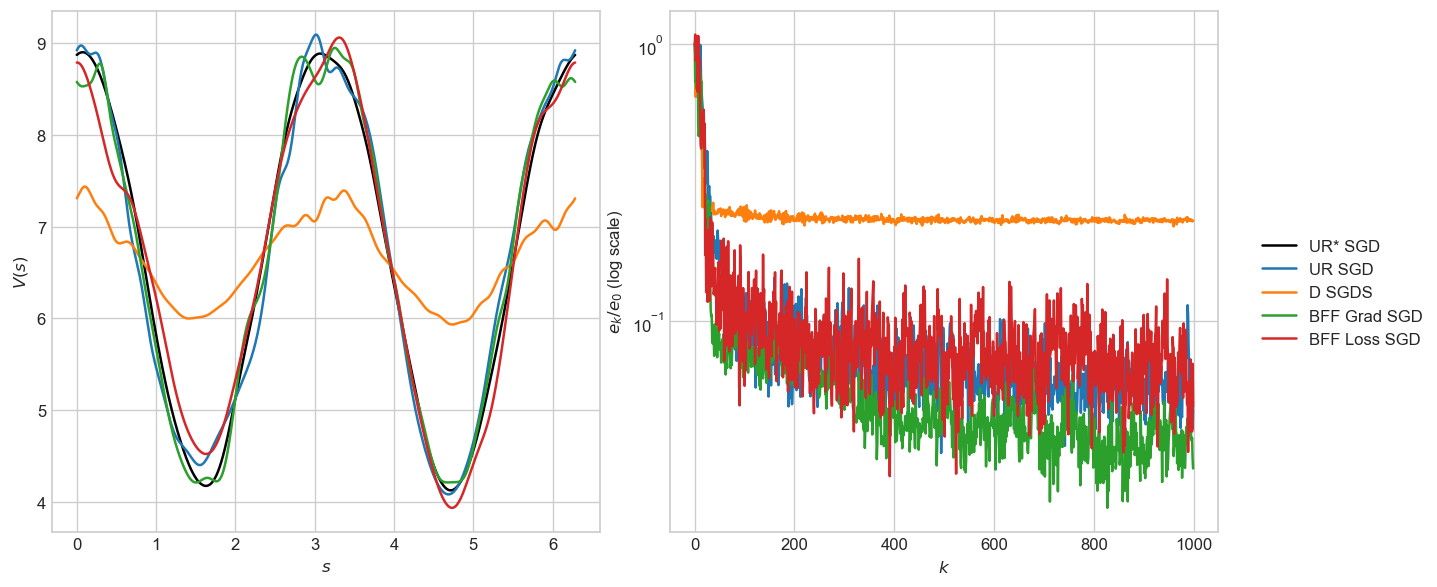

In [20]:
V_s = [V_UR_SGD, V_DS_SGD, V_BFF_G_SGD, V_BFF_L_SGD]
e_s = [e_UR_SGD, e_DS_SGD, e_BFF_G_SGD, e_BFF_L_SGD]
lb_s = ["UR SGD", "D SGDS", "BFF Grad SGD", "BFF Loss SGD"]
lb_star = "UR* SGD"
plotV(V_s, e_s, lb_s, V_UR_SGD_star, lb_star)
# plt.savefig("V_SGD_normal")

 ### CBO

In [21]:
def V_eval_CBO_gen(L_f):
    def algo(V_net=Net(), N=30, m=1000, epochs=100, S=S, α=α,σ=σ,ϵ=ϵ,γ=0.9,λ=1.,δ = 1e-3,
             τ_k=lambda k:0.1, η_k=lambda k:0.5, β_k=lambda k:10, V_net_comp=None, n_comp=1000):
        with torch.no_grad():
            V_θ = [Net() for _ in range(N)]
            rem = torch.tensor([])
            L = torch.empty(N)
            n = S.size()[0]
            n_params = sum(param.numel() for param in V_net.parameters())
            i = 0
            if V_net_comp:
                x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
                e = [comp(V_net,V_net_comp,x_ls, n_comp)]
            for k in trange(epochs, leave=False, position=0, desc="Epoch"):
                A, rem = gen_batches(n-2,m, rem)
                for A_θ in tqdm(A,leave=False, position=0, desc="Batch"):
                    β = β_k(i)
                    τ = τ_k(i)  
                    η = η_k(i)
                    i += 1 
                    L = L_f(V_θ,A_θ, m, γ, S=S,R=R, α=α,σ=σ, ϵ=ϵ)
                    μ = torch.exp(-β * L)
                    Δx̄2 = 0
                    # Update parameters
                    for x̄X_params in zip(V_net.parameters(),*[V_j.parameters() for V_j in V_θ]):
                        x̄ = x̄X_params[0]
                        X = torch.stack(x̄X_params[1:])
                        x̄_new = torch.einsum("i,i...->...", μ, X)/torch.sum(μ)
                        Δx̄2 += torch.norm(x̄ - x̄_new)**2
                        x̄.copy_(x̄_new)
                        z = torch.zeros(x̄.size())
                        for X_j in x̄X_params[1:]:
                            X_j += (-λ*η+τ*np.sqrt(η)*torch.normal(z))*(X_j-x̄)
                    # Brownian motion if change in V_net params below threshold
                    if (Δx̄2/n_params)<δ:
                        for X_params in zip(*[V_j.parameters() for V_j in V_θ]):
                            z = torch.zeros(X_params[0].size())
                            for X_j in X_params:
                                X_j += τ*np.sqrt(η)*torch.normal(z)
                    if V_net_comp:
                        e.append(comp(V_net,V_net_comp,x_ls, n_comp))
            if V_net_comp:
                return V_net, torch.tensor(e)
            else:
                return V_net
    return algo

In [22]:
def UR_CBO_L(V_θ,A_θ, m, γ, S=S,R=R, α=α,σ=σ, ϵ=ϵ):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    s_2 = S[A_θ+2]
    ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    f̂ = torch.cat([R[A_θ] + γ*V_j(ŝ_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f*f̂,0)/(2*m)

def DS_CBO_L(V_θ,A_θ, m, γ, S=S,R=R, α=None,σ=None, ϵ=None):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f**2,0)/(2*m)

def BFF_CBO_L(V_θ,A_θ, m, γ, S=S,R=R, α=None,σ=None, ϵ=None):
    s = S[A_θ]
    s_1 = S[A_θ+1]
    s_2 = S[A_θ+2]
    s̃_1 = s + s_2 - s_1
    f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
    f̃ = torch.cat([R[A_θ] + γ*V_j(s̃_1)-V_j(s) for V_j in V_θ],1)
    return torch.sum(f*f̃,0)/(2*m)

In [23]:
N = 30
m = 1000
epochs = 1
δ = 1e-5
# η_k = lambda k: 0.5*0.999**k
# τ_k = lambda k: 0.25*0.998**k
# β_k = lambda k: 30*1.002**k  
η_k = lambda k: max(0.5*0.998**k,0.01)
τ_k = lambda k: max(0.1*0.998**k,0.01)
β_k = lambda k: min(30*1.002**k,80)

In [24]:
# η_k(1000), τ_k(1000), β_k(1000)

In [28]:
V_UR_CBO, e_UR_CBO = V_eval_CBO_gen(UR_CBO_L)(N=N, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, δ=δ, V_net_comp = V_UR_SGD_star)
V_DS_CBO, e_DS_CBO = V_eval_CBO_gen(DS_CBO_L)(N=N, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, δ=δ,V_net_comp = V_UR_SGD_star)
V_BFF_CBO, e_BFF_CBO = V_eval_CBO_gen(BFF_CBO_L)(N=N, m=m,epochs=epochs, η_k=η_k, τ_k=τ_k, β_k=β_k, δ=δ,V_net_comp = V_UR_SGD_star)

Epoch: 100%|██████████| 1/1 [04:48<00:00, 288.35s/it]

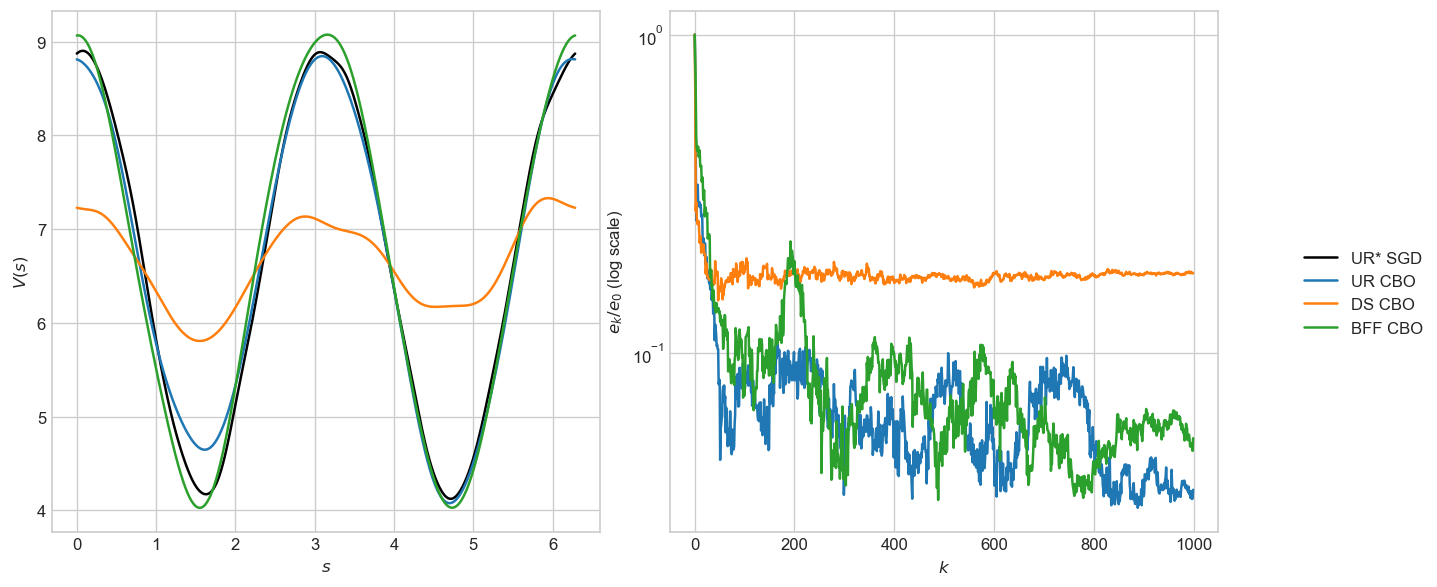

In [29]:
V_s = [V_UR_CBO, V_DS_CBO, V_BFF_CBO]
e_s = [e_UR_CBO, e_DS_CBO, e_BFF_CBO]
lb_s = ["UR CBO", "DS CBO", "BFF CBO"] 
lb_star = "UR* SGD"
plotV(V_s, e_s, lb_s, V_UR_SGD_star, lb_star)


In [30]:
def plotV2(V_dict, V_star, lb_star):
    n_r = len(V_dict)
    fig, axg = plt.subplots(figsize=(12,8),ncols=2, nrows=n_r)
    x_s = torch.linspace(0,2*np.pi,1000)
    y_star = V_star(x_s.view(-1,1)).view(-1)
    pad = 5
    for i, (plt_name, (V_s,e_s,lb_s,c_s,ls_s)) in enumerate(V_dict.items()):
        y_s = torch.cat([V(x_s.view(-1,1)).view(1,-1) for V in V_s])
        y_s -= torch.mean(y_s-y_star.view(1,-1),axis=1).view(-1,1)
        axr = axg[i] 
        axr[0].annotate(plt_name, xy=(0, 0.5), xytext=(-axr[0].yaxis.labelpad - pad, 0),
                xycoords=axr[0].yaxis.label, textcoords='offset points',
                size=15, ha='right', va='center')
        axr[0].plot(x_s.detach().numpy(),y_star.detach().numpy(),label=lb_star,color="black")
        for j in range(0,len(y_s)):
            axr[0].plot(x_s.detach().numpy(),y_s[j].detach().numpy(),label=lb_s[j],color=c_s[j],ls=ls_s[j])
            axr[1].plot(e_s[j]/e_s[j][0], label=lb_s[j],color=c_s[j],ls=ls_s[j])
        axr[0].set_ylabel(r"$V(s)$")
        axr[0].set_xlabel(r"$s$")
        axr[1].set_yscale("log")
        axr[1].set_ylabel(r"$e_k/e_0$ (log scale)")
        axr[1].set_xlabel(r"$k$")
    handles, labels = axg[-1,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    plt.tight_layout()
    plt.subplots_adjust(left=0.15,right=0.90)

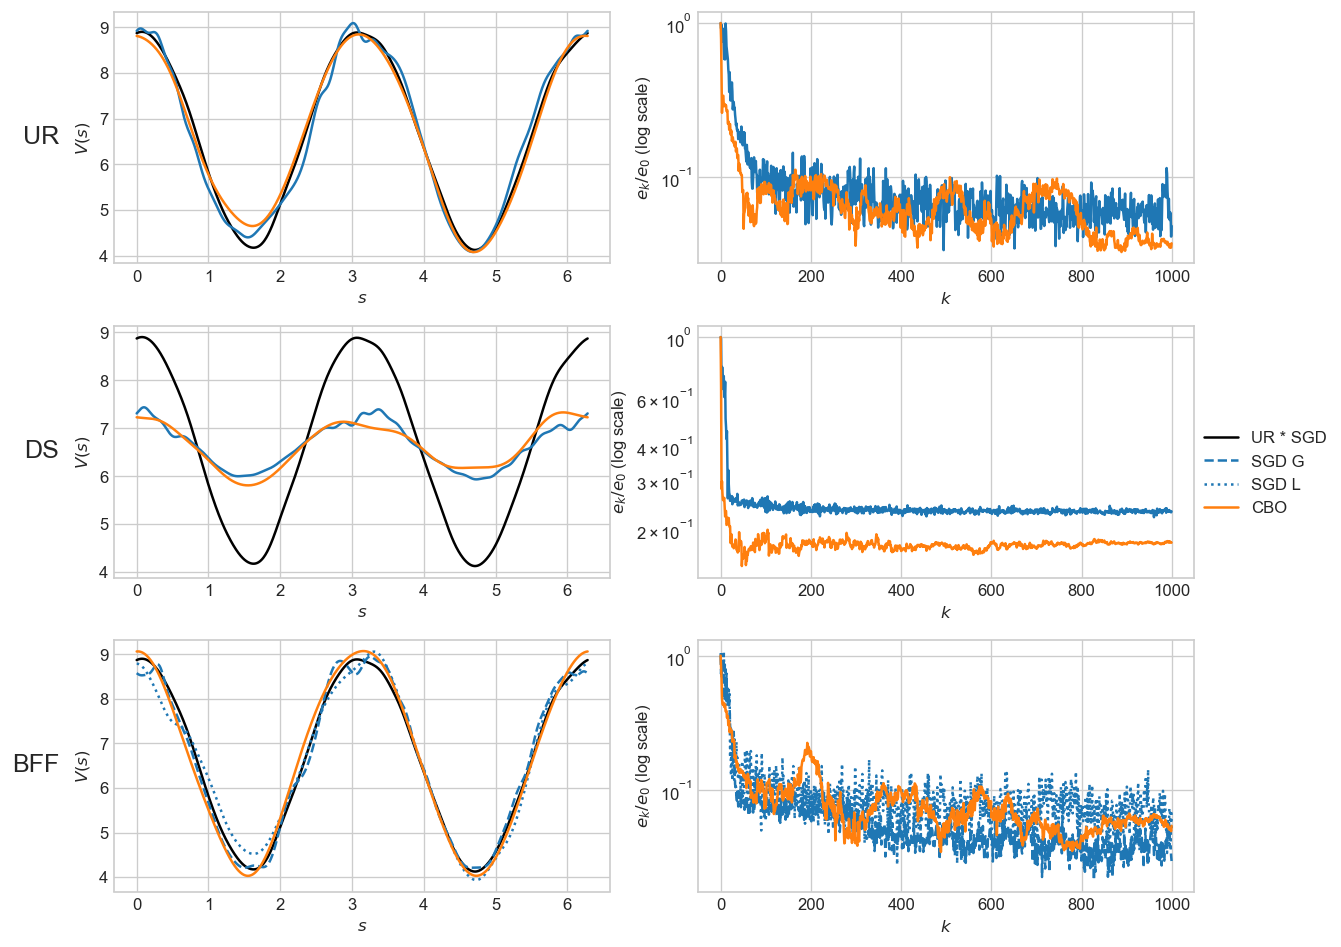

In [31]:
V_dict = {
    "UR": [
        [V_UR_SGD,V_UR_CBO],
        [e_UR_SGD,e_UR_CBO],
        ["SGD", "CBO"],
        ["C0","C1"],
        ["solid","solid"]
    ], 
    "DS": [
        [V_DS_SGD,V_DS_CBO],
        [e_DS_SGD,e_DS_CBO],
        ["SGD", "CBO"],
        ["C0","C1"],
        ["solid","solid"]
    ],
    "BFF": [
        [V_BFF_G_SGD,V_BFF_L_SGD,V_BFF_CBO],
        [e_BFF_G_SGD,e_BFF_L_SGD,e_BFF_CBO],
        ["SGD G","SGD L", "CBO"],
        ["C0","C0", "C1"],
        ["dashed","dotted","solid"]
    ]
}
plotV2(V_dict, V_UR_SGD_star, "UR * SGD")
plt.savefig("V_SGD_vs_CBO_yuhua")

## $Q$-evaluation and control, continuous state space (4.1.)


 ### Outline

 - MDP with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
 - Dynamics described by

 $$
 \begin{aligned}
 &\Delta s_{m} = a_m\epsilon + \sigma \sqrt{\epsilon} Z_m\\
 &a_m \in\mathbb A = \{\pm 1\}\\
 &a_m\sim \pi(\cdot|s_{m-1})\\
 &\varepsilon = \frac{2\pi}{32}\\
 &\sigma = 0.2\\
 &r(s_{m+1},s_{m},a_m) = \sin(s_{m+1})+1
 \end{aligned}
 $$

 - 3 layer FCNN, $Q^\pi(s,a;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons. Output layer of size $|\mathbb A|$.

 ### $Q$-evaluation

 Estimating $Q^\pi$ for fixed policy $\pi(a|s)=1/2 + a \sin(s)/5$.
 $$j^{eval}(s_m, a_m, s_{m+1};\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \int Q^\pi(s_{m+1},a;\theta)\pi(a|s_{m+1})da - Q^\pi(s_m,a_m;\theta)$$

In [6]:
from torch.distributions.categorical import Categorical 

In [7]:
π = lambda a, s: 1/2 + a*torch.sin(s)/5
σ = 0.2
ϵ = 2.*np.pi/32.
s_0 = torch.tensor([0.])
r = lambda s: torch.sin(s)+1
a_s = torch.tensor([-1.,1.])

In [8]:
def sample_policy(s_0, π, σ, ϵ, a_s, m):
    s_0 = s_0.view(s_0.size()[0],-1)
    s_0_size = s_0.size()
    S = torch.zeros(m,*s_0_size)
    S[0] = s_0
    A_idx = torch.zeros(m,s_0_size[0])
    for i in trange(m-1):
        for j, s in enumerate(S[i]):
            A_idx[i,j] = Categorical(probs=π(a_s,s)).sample()
            a = A_idx[i,j]*2. - 1.
            S[i+1,j] = s+a*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    return S.view(-1,1), A_idx.view(-1,1)

In [52]:
# S,A_idx = sample_policy(s_0, π, σ, ϵ, a_s, int(1e6))
# R = r(S) 
# S_long, A_idx_long = sample_policy(s_0, π, σ, ϵ, a_s, int(1e7))
# R_long = r(S_long) 

In [53]:
# torch.save(S_long, 'S_long_1.pt')
# torch.save(A_idx_long, 'A_idx_long_1.pt')
# torch.save(R_long, 'R_long_1.pt')
# torch.save(S, 'S_1.pt')
# torch.save(A_idx, 'A_idx_1.pt')
# torch.save(R, 'R_1.pt')

In [9]:
S_long = torch.load('S_long_1.pt')
R_long = torch.load('R_long_1.pt')
A_idx_long = torch.load('A_idx_long_1.pt')
S = torch.load('S_1.pt')
R = torch.load('R_1.pt')
A_idx = torch.load('A_idx_1.pt')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)
        self.apply(self.init_params)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

    def init_params(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight)
            nn.init.normal_(m.bias)

In [11]:
def comp(Q_net,Q_net_comp,x_ls, n):
    diff = Q_net(x_ls)-Q_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff-torch.mean(diff,axis=0))
def comp_0(Q_net,Q_net_comp,x_ls, n):
    diff = Q_net(x_ls)-Q_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff)

In [12]:
def Q_SGD_gen(update_step):
    def algo(Q_net=Net(), M=1000, epochs=100, γ=0.9, τ=0.01, S=S, A_idx=A_idx, R=R, a_s=a_s, π=π, σ=σ, ϵ=ϵ, Q_net_comp=None, n=1000):
        Rem = torch.tensor([])
        N = S.size()[0]
        if Q_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(Q_net,Q_net_comp,x_ls, n)]
        for k in trange(epochs, leave=False, position=0, desc="Epoch"):
            B, Rem = gen_batches(N-2,M, Rem)
            for i,B_θ in enumerate(tqdm(B,leave=False, position=0,desc="Batch")): 
                update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ,M,π=π, σ=σ, ϵ=ϵ)                
                with torch.no_grad():
                    for param in Q_net.parameters():
                        param -= τ/M*param.grad
                if Q_net_comp:
                    e.append(comp(Q_net,Q_net_comp,x_ls, n))
        if Q_net_comp:
            return Q_net, torch.tensor(e)
        else:
            return Q_net
    return algo

def Q_eval_UR_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ,M, π=π, σ=σ, ϵ=ϵ):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
    ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
    ĵ = r + γ*torch.sum(Q_net(ŝ_1)*π(a_s,ŝ_1),axis=1) - q
    Q_net.zero_grad()
    ĵ.backward(j)
def Q_eval_DS_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ, M,π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
    Q_net.zero_grad()
    j.backward(j)

def Q_eval_BFF_G_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ,M, π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s+s_2-s_1
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
    j̃ = r + γ*torch.sum(Q_net(s̃_1)*π(a_s,s̃_1),axis=1) - q
    Q_net.zero_grad()
    (j*j̃).backward(torch.ones_like(j)/2.)
    
    
def Q_eval_BFF_L_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ,M, π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s+s_2-s_1
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.sum(Q_net(s_1)*π(a_s,s_1),axis=1) - q
    j̃ = r + γ*torch.sum(Q_net(s̃_1)*π(a_s,s̃_1),axis=1) - q
    Q_net.zero_grad()
    j̃.backward(j)

In [13]:
Q_eval_UR_SGD_star = Q_SGD_gen(Q_eval_UR_SGD_update_step)(S=S_long, R=R_long, A_idx=A_idx_long, M=1000, epochs=10, τ=0.01)

Epoch: 100%|██████████| 10/10 [59:11<00:00, 356.07s/it]

In [14]:
# torch.save(Q_eval_UR_SGD_star, "Q_eval_UR_SGD_star.pt")
Q_eval_UR_SGD_star = torch.load("Q_eval_UR_SGD_star.pt")

In [15]:
Q_eval_UR_SGD, e_UR_SGD = Q_SGD_gen(Q_eval_UR_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_DS_SGD, e_DS_SGD = Q_SGD_gen(Q_eval_DS_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_BFF_G_SGD, e_BFF_G_SGD = Q_SGD_gen(Q_eval_BFF_G_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_BFF_L_SGD, e_BFF_L_SGD = Q_SGD_gen(Q_eval_BFF_L_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)

Epoch: 100%|██████████| 1/1 [00:12<00:00, 12.94s/it]

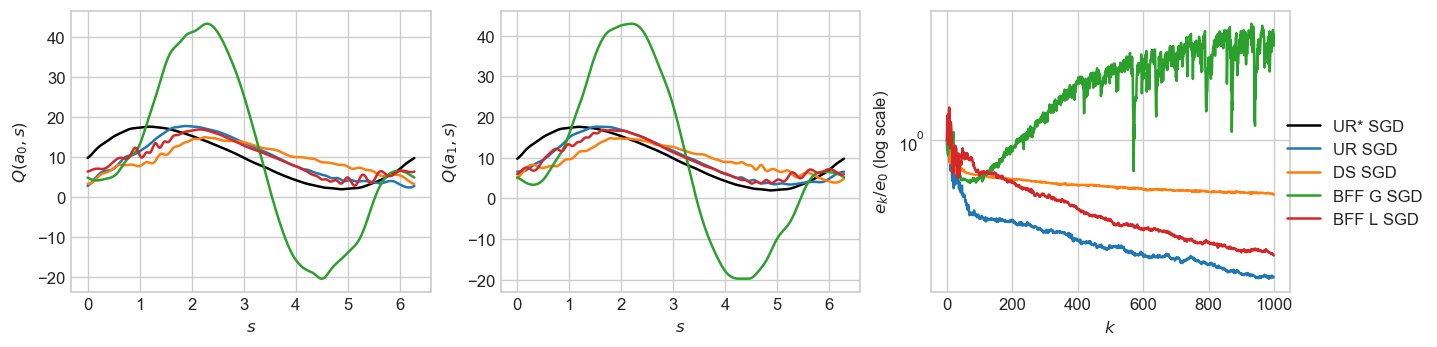

In [16]:
def plotQ(Q_s, e_s, lb_s, Q_star, lb_star):
    a_n = len(a_s)
    n = len(Q_s)
    fig, axs = plt.subplots(figsize=(12,3),ncols=a_n+1)
    x_s = torch.linspace(0,2*np.pi,1000)
    y_star = Q_star(x_s.view(-1,1))
    y_s = torch.cat([Q(x_s.view(-1,1)).view(1,-1,a_n) for Q in Q_s])
    y_s -= torch.mean(y_s-y_star.expand(n,-1,a_n),axis=1).view(n,-1,a_n)
    for i in range(a_n):
        axs[i].plot(x_s.detach().numpy(),y_star[:,1].detach().numpy(),label=lb_star, color="black")
        axs[i].set_ylabel(f"$Q(a_{i},s)$")
        axs[i].set_xlabel(r"$s$")

    for j in range(n):
        for i in range(a_n):
            axs[i].plot(x_s.detach().numpy(),y_s[j,:,i].detach().numpy(),label=lb_s[j])
        axs[a_n].plot(e_s[j]/e_s[j][0], label=lb_s[j])
    axs[a_n].set_yscale("log")
    axs[a_n].set_ylabel(r"$e_k/e_0$ (log scale)")
    axs[a_n].set_xlabel(r"$k$")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)

Q_s = [Q_eval_UR_SGD,Q_eval_DS_SGD,Q_eval_BFF_G_SGD,Q_eval_BFF_L_SGD]
e_s = [e_UR_SGD,e_DS_SGD,e_BFF_G_SGD,e_BFF_L_SGD]
lb_s = ["UR SGD","DS SGD","BFF G SGD", "BFF L SGD"]
plotQ(Q_s,e_s,lb_s, Q_eval_UR_SGD_star, "UR* SGD")

 ### $Q$-control

 Fixed behaviour policy to genearte training trajectory, $\pi(a|s)=1/|\mathbb A|$.

 $$j^{ctrl}(s_m, a_m, s_m+1;\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \max_{a'} Q^\pi(s_{m+1},a';\theta) - Q^\pi(s_m,a_m;\theta)$$

In [18]:
π = lambda a, s: torch.tensor([1/2.,1/2.])*torch.ones_like(s)
σ = 0.2
ϵ = 2.*np.pi/32.
s_0 = torch.tensor([0.])
r = lambda s: torch.sin(s)+1
a_s = torch.tensor([-1.,1.])


In [20]:
# S, A_idx = sample_policy(s_0, π, σ, ϵ, a_s, int(1e6))
# R = r(S) 
# S_long, A_idx_long = sample_policy(s_0, π, σ, ϵ, a_s, int(1e7))
# R_long = r(S_long) 


In [21]:
# torch.save(S_long, 'S_long_2.pt')
# torch.save(A_idx_long, 'A_idx_long_2.pt')
# torch.save(R_long, 'R_long_2.pt')
# torch.save(S, 'S_2.pt')
# torch.save(A_idx, 'A_idx_2.pt')
# torch.save(R, 'R_2.pt')

In [22]:
S_long = torch.load('S_long_2.pt')
R_long = torch.load('R_long_2.pt')
A_idx_long = torch.load('A_idx_long_2.pt')
S = torch.load('S_2.pt')
R = torch.load('R_2.pt')
A_idx = torch.load('A_idx_2.pt')


 #### SGD

In [23]:
def Q_ctrl_UR_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ, π=π, σ=σ, ϵ=ϵ):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
    ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
    ĵ = r + γ*torch.max(Q_net(ŝ_1),axis=1).values - q
    Q_net.zero_grad()
    ĵ.backward(j)

def Q_ctrl_DS_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ, π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
    Q_net.zero_grad()
    j.backward(j)

def Q_ctrl_BFF_G_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ, π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s+s_2-s_1
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
    j̃ = r + γ*torch.max(Q_net(s̃_1),axis=1).values - q
    Q_net.zero_grad()
    (j*j̃).backward(torch.ones_like(j)/2.)
    
    
def Q_ctrl_BFF_L_SGD_update_step(Q_net, γ, τ, S, A_idx, R, a_s, B_θ, π=None, σ=None, ϵ=None):     
    s = S[B_θ]
    r = R[B_θ].view(-1)
    a_idx = A_idx[B_θ].type(torch.LongTensor).view(-1)
    s_1 = S[B_θ+1]
    s_2 = S[B_θ+2]
    s̃_1 = s+s_2-s_1
    q = Q_net(s)[np.arange(M),a_idx]
    j = r + γ*torch.max(Q_net(s_1),axis=1).values - q
    j̃ = r + γ*torch.max(Q_net(s̃_1),axis=1).values - q
    Q_net.zero_grad()
    j̃.backward(j)

In [25]:
Q_ctrl_UR_SGD_star = Q_SGD_gen(Q_ctrl_UR_SGD_update_step)(S=S_long, R=R_long, M=1000, epochs=10, τ=0.01)

Batch:   0%|          | 0/9999 [00:00<?, ?it/s]

TypeError: Q_ctrl_UR_SGD_update_step() got multiple values for argument 'π'

In [ ]:
torch.save(Q_eval_UR_SGD_star, "Q_eval_UR_SGD_star.pt")
Q_eval_UR_SGD_star = torch.load("Q_eval_UR_SGD_star.pt")



In [ ]:
Q_eval_UR_SGD, e_UR_SGD = Q_SGD_gen(Q_eval_UR_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_DS_SGD, e_DS_SGD = Q_SGD_gen(Q_eval_DS_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_BFF_G_SGD, e_BFF_G_SGD = Q_SGD_gen(Q_eval_BFF_G_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_eval_BFF_L_SGD, e_BFF_L_SGD = Q_SGD_gen(Q_eval_BFF_L_SGD_update_step)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)

In [ ]:
Q_s = [Q_UR,Q_DS,Q_BFF]
e_s = [e_UR,e_DS,e_BFF]
lb_s = ["UR","DS","BFF"]
plotQ(Q_s,e_s,lb_s, )

In [ ]:
def Q_CBO_gen(L_f):
    def algo(Q_net=Net(), N=30, m=1000, epochs=100, S=S,A_idx=A_idx, R=R, a_s=a_s, π=π,σ=σ,ϵ=ϵ,γ=0.9,λ=1.,δ = 1e-3,
             τ_k=lambda k:0.1, η_k=lambda k:0.5, β_k=lambda k:10, V_net_comp=None, n_comp=1000):
        with torch.no_grad():
            Q_θ = [Net() for _ in range(N)]
            rem = torch.tensor([])
            L = torch.empty(N)
            n = S.size()[0]
            n_params = sum(param.numel() for param in V_net.parameters())
            i = 0
            if Q_net_comp:
                x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
                e = [comp(Q_net,Q_net_comp,x_ls, n_comp)]
            for k in trange(epochs, leave=False, position=0, desc="Epoch"):
                A, rem = gen_batches(n-2,m, rem)
                for A_θ in tqdm(A,leave=False, position=0, desc="Batch"):
                    β = β_k(i)
                    τ = τ_k(i)  
                    η = η_k(i)
                    i += 1 
                    L = L_f(Q_θ,A_θ, m, γ, S,A_idx, R, a_s, π=π,σ=σ,ϵ=ϵ)
                    μ = torch.exp(-β * L)
                    Δx̄2 = 0
                    # Update parameters
                    for x̄X_params in zip(Q_net.parameters(),*[Q_j.parameters() for Q_j in Q_θ]):
                        x̄ = x̄X_params[0]
                        X = torch.stack(x̄X_params[1:])
                        x̄_new = torch.einsum("i,i...->...", μ, X)/torch.sum(μ)
                        Δx̄2 += torch.norm(x̄ - x̄_new)**2
                        x̄.copy_(x̄_new)
                        z = torch.zeros(x̄.size())
                        for X_j in x̄X_params[1:]:
                            X_j += (-λ*η+τ*np.sqrt(η)*torch.normal(z))*(X_j-x̄)
                    # Brownian motion if change in V_net params below threshold
                    if (Δx̄2/n_params)<δ:
                        for X_params in zip(*[Q_j.parameters() for Q_j in Q_θ]):
                            z = torch.zeros(X_params[0].size())
                            for X_j in X_params:
                                X_j += τ*np.sqrt(η)*torch.normal(z)
                    if Q_net_comp:
                        e.append(comp(Q_net,Q_net_comp,x_ls, n_comp))
            if Q_net_comp:
                return Q_net, torch.tensor(e)
            else:
                return Q_net
    return algo

In [ ]:
def Q_ctrl_UR_CBO_L(Q_θ,A_θ, m, γ, S,A_idx, R, a_s, π=π,σ=σ,ϵ=ϵ):     
    s = S[A_θ]
    r = R[A_θ].view(-1)
    a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
    s_1 = S[A_θ+1]
    â = torch.tensor([Categorical(probs=π_).sample() for π_ in π(a_s,s)]).view(*s.size())*2 - 1
    ŝ_1 = s+â*ϵ+σ*np.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
    j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
    ĵ = torch.cat([(r + γ*torch.max(Q_j(ŝ_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
    return torch.sum(j*ĵ,0)/(2*m)

def Q_ctrl_UR_CBO_L(Q_θ,A_θ, m, γ, S,A_idx, R, a_s, π=None,σ=None,ϵ=None):     
    s = S[A_θ]
    r = R[A_θ].view(-1)
    a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
    s_1 = S[A_θ+1]
    j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
    return torch.sum(j**2,0)/(2*m)

def Q_ctrl_BFF_CBO_L(Q_θ,A_θ, m, γ, S,A_idx, R, a_s, π=None,σ=None,ϵ=None):     
    s = S[A_θ]
    r = R[A_θ].view(-1)
    a_idx = A_idx[A_θ].type(torch.LongTensor).view(-1)
    s_1 = S[A_θ+1]
    s_2 = S[A_θ+2]
    s̃_1 = s+s_2-s_1
    j = torch.cat([(r + γ*torch.max(Q_j(s_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
    j̃ = torch.cat([(r + γ*torch.max(Q_j(s̃_1),axis=1).values - Q_j(s)[np.arange(m),a_idx]).view(-1,1) for Q_j in Q_θ],1)
    return torch.sum(j*j̃,0)/(2*m)

In [ ]:
N = 30
m = 1000
epochs = 1
δ = 1e-5
η_k = lambda k: 0.5*0.999**k
τ_k = lambda k: 0.1*0.9999**k
β_k = lambda k: 30*1.0002**k  

In [ ]:
η_k(1000), τ_k(1000), β_k(1000)

In [ ]:
Q_ctrl_UR_CBO, Q_ctrl_UR_CBO = Q_CBO_gen(Q_ctrl_UR_CBO_L)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_ctrl_DS_CBO, Q_ctrl_UR_CBO = Q_CBO_gen(Q_ctrl_DS_CBO_L)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)
Q_ctrl_BFF_CBO, Q_ctrl_UR_CBO = Q_CBO_gen(Q_ctrl_BFF_CBO_L)(M=1000, epochs=1, τ=0.1, Q_net_comp = Q_eval_UR_SGD_star)

In [ ]:

# def plotQ2(Q_dict, Q_star, lb_star):
#     n_r = len(V_dict)
#     fig, axg = plt.subplots(figsize=(12,8),ncols=3, nrows=n_r)
#     x_s = torch.linspace(0,2*np.pi,100)
#     y_star = Q_star(x_s.view(-1,1)).view(-1)
#     pad = 5
#     for i, (plt_name, (V_s,e_s,lb_s,c_s,ls_s)) in enumerate(V_dict.items()):
#         y_s = torch.cat([V(x_s.view(-1,1)).view(1,-1) for V in V_s])
#         y_s -= torch.mean(y_s-y_star.view(1,-1),axis=1).view(-1,1)
#         axr = axg[i] 

#         axr[0].annotate(plt_name, xy=(0, 0.5), xytext=(-axr[0].yaxis.labelpad - pad, 0),
#                 xycoords=axr[0].yaxis.label, textcoords='offset points',
#                 size=15, ha='right', va='center')

#         axr[0].plot(x_s.detach().numpy(),y_star.detach().numpy(),label=lb_star,color="black")
#         for j in range(0,len(y_s)):
#             axr[0].plot(x_s.detach().numpy(),y_s[j].detach().numpy(),label=lb_s[j],color=c_s[j],ls=ls_s[j])
#             axr[1].plot(e_s[j]/e_s[j][0], label=lb_s[j],color=c_s[j],ls=ls_s[j])
#         axr[0].set_ylabel(r"$V(s)$")
#         axr[0].set_xlabel(r"$s$")
#         axr[1].set_yscale("log")
#         axr[1].set_ylabel(r"$e_k/e_0$ (log scale)")
#         axr[1].set_xlabel(r"$k$")
#     handles, labels = axg[-1,0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='center right')
#     plt.tight_layout()
#     plt.subplots_adjust(left=0.15,right=0.90)
# def plotQ2(Q_dict, Q_star, lb_star):
#     n_r = len(V_dict)
#     fig, axg = plt.subplots(figsize=(12,8),ncols=3, nrows=n_r)
#     x_s = torch.linspace(0,2*np.pi,100)
#     y_star = Q_star(x_s.view(-1,1)).view(-1)
#     pad = 5
#     for i, (plt_name, (V_s,e_s,lb_s,c_s,ls_s)) in enumerate(V_dict.items()):
#         y_s = torch.cat([V(x_s.view(-1,1)).view(1,-1) for V in V_s])
#         y_s -= torch.mean(y_s-y_star.view(1,-1),axis=1).view(-1,1)
#         axr = axg[i] 

#         axr[0].annotate(plt_name, xy=(0, 0.5), xytext=(-axr[0].yaxis.labelpad - pad, 0),
#                 xycoords=axr[0].yaxis.label, textcoords='offset points',
#                 size=15, ha='right', va='center')

#         axr[0].plot(x_s.detach().numpy(),y_star.detach().numpy(),label=lb_star,color="black")
#         for j in range(0,len(y_s)):
#             axr[0].plot(x_s.detach().numpy(),y_s[j].detach().numpy(),label=lb_s[j],color=c_s[j],ls=ls_s[j])
#             axr[1].plot(e_s[j]/e_s[j][0], label=lb_s[j],color=c_s[j],ls=ls_s[j])
#         axr[0].set_ylabel(r"$V(s)$")
#         axr[0].set_xlabel(r"$s$")
#         axr[1].set_yscale("log")
#         axr[1].set_ylabel(r"$e_k/e_0$ (log scale)")
#         axr[1].set_xlabel(r"$k$")
#     handles, labels = axg[-1,0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='center right')
#     plt.tight_layout()
#     plt.subplots_adjust(left=0.15,right=0.90)

In [ ]:
# V_dict = {
#     "UR": [
#         [V_UR_SGD,V_UR_CBO],
#         [e_UR_SGD,e_UR_CBO],
#         ["SGD", "CBO"],
#         ["C0","C1"],
#         ["solid","solid"]
#     ], 
#     "DS": [
#         [V_DS_SGD,V_DS_CBO],
#         [e_DS_SGD,e_DS_CBO],
#         ["SGD", "CBO"],
#         ["C0","C1"],
#         ["solid","solid"]
#     ],
#     "BFF": [
#         [V_BFF_G_SGD,V_BFF_L_SGD,V_BFF_CBO],
#         [e_BFF_G_SGD,e_BFF_L_SGD,e_BFF_CBO],
#         ["SGD G","SGD L", "CBO"],
#         ["C0","C0", "C1"],
#         ["dashed","dotted","solid"]
#     ]
# }
# plotV2(V_dict, V_UR_SGD_star, "UR * SGD")